In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


## Get Modified Dataset for Training

In [19]:

# Loading feather files
if True:
    Combined_Feature_train_df = pd.read_feather('Garbage_data/Combined_Feature_train.feather')
    Combined_Feature_val_df = pd.read_feather('Garbage_data/Combined_Feature_val.feather')

In [20]:
if True:
    # Combine train and validation set for cross validation tests

    Full_df = pd.concat((Combined_Feature_train_df, Combined_Feature_val_df), axis=0)
    X_train = Full_df.iloc[:, :-1].values
    y_train = Full_df['label'].values
else:
    # seperate training and validation dataframes between features and labels for manual training

    X_train = Combined_Feature_train_df.iloc[:, :-1].values
    X_val = Combined_Feature_val_df.iloc[:, :-1].values

    y_train = Combined_Feature_train_df['label'].values
    y_val = Combined_Feature_val_df['label'].values

## Pipeline

In [21]:
scaler = StandardScaler()
validation_scores = {}

In [ ]:
# SVM pipeline using one-vs-one organization to do multi-class classification
SVM_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=50)),
                ('svc', svm.SVC(kernel='rbf', decision_function_shape='ovo', C=0.5))])

In [23]:
# performs cross validation with our just our training set

train_sizes, train_scores, val_scores = learning_curve(
    SVM_pipe,
    X_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 6),
    scoring="accuracy",
    n_jobs=-1
)

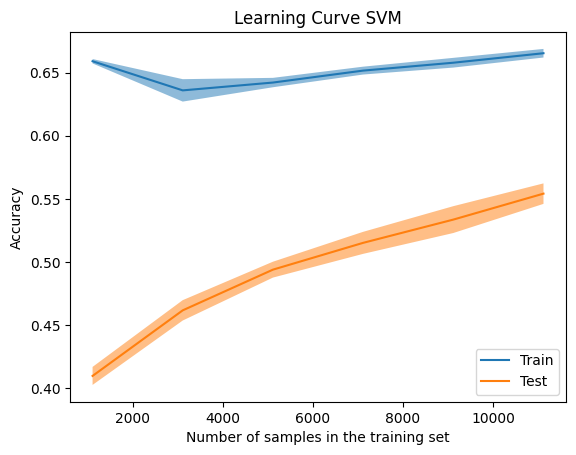

In [24]:
# display results of learning curve scores

disp = LearningCurveDisplay(
    train_sizes=train_sizes,
    train_scores=train_scores,
    test_scores=val_scores,
    score_name="Accuracy"
)

disp.plot()
plt.title("Learning Curve SVM")
plt.show()

In [25]:
validation_scores['SVM'] = val_scores
val_scores

array([[0.40309241, 0.40107914, 0.42086331, 0.41294964, 0.41079137],
       [0.45127652, 0.46115108, 0.47589928, 0.45791367, 0.46223022],
       [0.48795397, 0.48597122, 0.50179856, 0.49388489, 0.5       ],
       [0.50593312, 0.51115108, 0.52841727, 0.50791367, 0.52230216],
       [0.52175476, 0.5352518 , 0.54784173, 0.52122302, 0.54172662],
       [0.54261057, 0.56115108, 0.56151079, 0.54604317, 0.55935252]])

In [26]:
# RandomForest pipeline
RF_pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=50)),
                ('rf', RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=8))])

In [27]:
# performs cross validation using RandomForest Estimator


train_sizes, train_scores, val_scores = learning_curve(
    RF_pipe,
    X_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 6),
    scoring="accuracy",
    n_jobs=-1
)

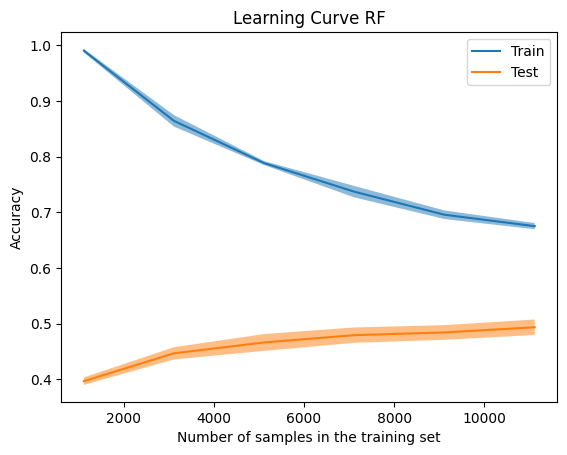

In [28]:
# display results of learning curve scores

disp = LearningCurveDisplay(
    train_sizes=train_sizes,
    train_scores=train_scores,
    test_scores=val_scores,
    score_name="Accuracy"
)


disp.plot()
plt.title("Learning Curve RF")
plt.show()


In [29]:
validation_scores['RF'] = val_scores
val_scores

array([[0.38511327, 0.39820144, 0.40431655, 0.39388489, 0.40179856],
       [0.44768069, 0.43021583, 0.46402878, 0.44208633, 0.44964029],
       [0.46134484, 0.44100719, 0.48057554, 0.46546763, 0.48273381],
       [0.48291981, 0.45467626, 0.49460432, 0.47589928, 0.48884892],
       [0.49119022, 0.46510791, 0.49136691, 0.47266187, 0.50071942],
       [0.48579648, 0.48273381, 0.50755396, 0.47877698, 0.51294964]])

## Confidence Interval

In [30]:
sample_sizes = np.linspace(0.1, 1.0, 6)


In [31]:
# Hard code t score from table for 95% confidence
t_score = 2.776


SVM_mean = validation_scores['SVM'].mean(axis=1)
RF_mean = validation_scores['RF'].mean(axis=1)

SVM_std = validation_scores['SVM'].std(ddof=1, axis=1)
RF_std = validation_scores['RF'].std(ddof=1, axis=1)

In [32]:
# Compute the confidence interval
def confidence_interval(mean, std, k, crit_val):
    
    lower = mean - (crit_val * (std/(k**0.5)))
    upper = mean + (crit_val * (std/(k**0.5)))

    return np.array([lower, upper])

In [33]:
for mean, std, sample_size in zip(SVM_mean, SVM_std, sample_sizes):
    SVM_range = confidence_interval(mean = mean, std = std, k =5, crit_val=t_score)
    print(f'Confidence Interval for SVM model with sample size {sample_size:0.2f} and 95% confidence is {SVM_range[0]*100:0.2f}% - {SVM_range[1]*100:0.2f}%')


Confidence Interval for SVM model with sample size 0.10 and 95% confidence is 39.99% - 41.97%
Confidence Interval for SVM model with sample size 0.28 and 95% confidence is 45.05% - 47.29%
Confidence Interval for SVM model with sample size 0.46 and 95% confidence is 48.52% - 50.27%
Confidence Interval for SVM model with sample size 0.64 and 95% confidence is 50.30% - 52.73%
Confidence Interval for SVM model with sample size 0.82 and 95% confidence is 51.88% - 54.83%
Confidence Interval for SVM model with sample size 1.00 and 95% confidence is 54.29% - 56.54%


In [34]:
for mean, std, sample_size in zip(RF_mean, RF_std, sample_sizes):

    RF_range = confidence_interval(mean=mean, std=std, k=5, crit_val=t_score)
    print(f'Confidence Interval for RF model with sample size {sample_size:0.2f} and 95% confidence is {RF_range[0]*100:0.2f}% - {RF_range[1]*100:0.2f}%')


Confidence Interval for RF model with sample size 0.10 and 95% confidence is 38.73% - 40.60%
Confidence Interval for RF model with sample size 0.28 and 95% confidence is 43.15% - 46.20%
Confidence Interval for RF model with sample size 0.46 and 95% confidence is 44.53% - 48.72%
Confidence Interval for RF model with sample size 0.64 and 95% confidence is 46.02% - 49.86%
Confidence Interval for RF model with sample size 0.82 and 95% confidence is 46.59% - 50.25%
Confidence Interval for RF model with sample size 1.00 and 95% confidence is 47.43% - 51.29%
